In [1]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
#plt.style.use('ggplot')

In [2]:
df = pd.read_excel('a1410.xlsx')

In [3]:
#解决中文显示问题
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [4]:
df.tail()

,日期,货量
721,2022-12-27,28259
722,2022-12-28,37386
723,2022-12-29,23519
724,2022-12-30,20311
725,2022-12-31,25664


In [5]:
## Cleaning up the data
df.columns=["日期","货量"]
df.head()

,日期,货量
0,2021-01-01,23
1,2021-01-02,2
2,2021-01-03,2
3,2021-01-04,1
4,2021-01-05,14


In [6]:
# Convert Month into Datetime
df['日期']=pd.to_datetime(df['日期'])

In [7]:
df.head()

,日期,货量
0,2021-01-01,23
1,2021-01-02,2
2,2021-01-03,2
3,2021-01-04,1
4,2021-01-05,14


In [8]:
df.set_index('日期',inplace=True)

In [9]:
df.head()

,货量
日期,
2021-01-01,23
2021-01-02,2
2021-01-03,2
2021-01-04,1
2021-01-05,14


In [10]:
df.describe()

,货量
count,726.000000
mean,3034.359504
std,10656.313044
min,1.000000
25%,8.000000
50%,29.000000
75%,142.750000
max,83875.000000


<Axes: xlabel='日期'>

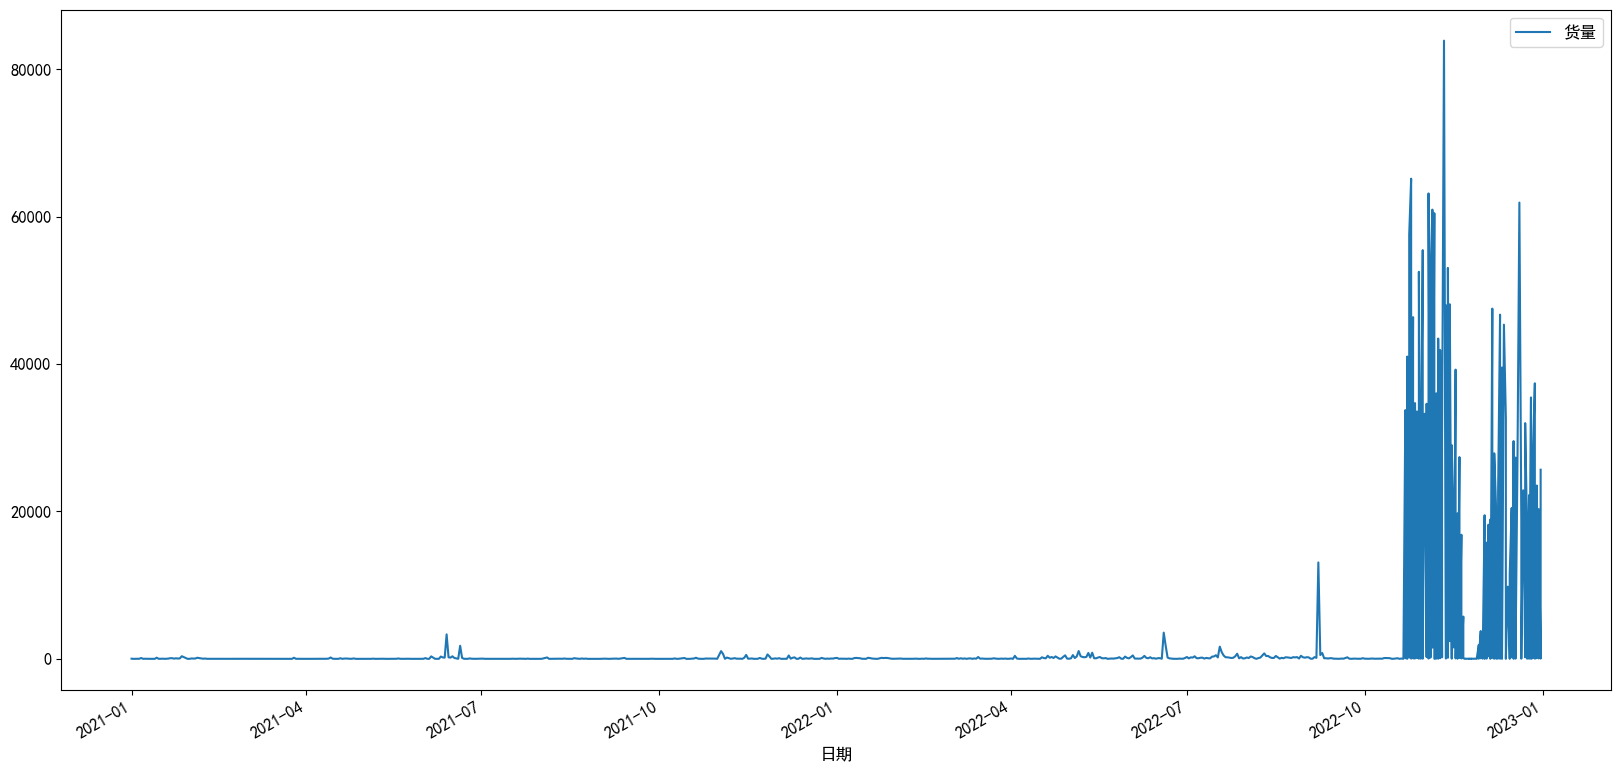

In [11]:
df.plot()

In [12]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

In [13]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [14]:
train_data = df['2021-10-01':'2022-10-01']
test_data = df['2022-10-02':'2022-12-31']

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [ ]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

In [ ]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

In [ ]:
results.plot_diagnostics(figsize=(20, 14))
plt.savefig("1410a.png")
plt.show()

In [ ]:
pred0 = results.get_prediction(start='2021-11-01', dynamic=False)
pred0_ci = pred0.conf_int()

In [ ]:
pred1 = results.get_prediction(start='2021-11-01', dynamic=True)
pred1_ci = pred1.conf_int()

In [ ]:
pred2 = results.get_forecast('2023-02-01')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['2023-01-01':'2023-01-31'])

In [ ]:
ax = df.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('数量')
plt.xlabel('Date')
plt.legend()
plt.savefig("1410预测.png")
plt.show()